### Dataset

In [396]:
import pandas as pd
from datasets import Dataset

df1 = pd.read_json('detection_dataset_1st_iter.jsonl', lines=True)
df2 = pd.read_json('detection_dataset_2nd_iter.jsonl', lines=True)
df3 = pd.read_json('detection_dataset_3rd_iter_2e-5.jsonl', lines=True)
df4 = pd.read_json('detection_dataset_3rd_iter_2e-4.jsonl', lines=True)
df5 = pd.read_json('detection_dataset_3rd_iter_2e-4_v2.jsonl', lines=True)

combined_df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True).drop_duplicates()
dataset = Dataset.from_pandas(combined_df)

# for final evaluation
dataset_survey = Dataset.from_pandas(pd.read_json('survey/samples_for_survey.jsonl', lines=True))

In [361]:
import numpy as np
import evaluate
from sklearn.metrics import fbeta_score

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
roc_auc_metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    prediction_scores = predictions[:, 1]
    predicted_labels = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predicted_labels, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predicted_labels, references=labels, average='weighted')["precision"],
        "recall": recall_metric.compute(predictions=predicted_labels, references=labels, average='weighted')["recall"],
        "f1": f1_metric.compute(predictions=predicted_labels, references=labels, average='weighted')["f1"],
        "f2": fbeta_score(labels, predicted_labels, beta=2, average="weighted"),
        "roc_auc": roc_auc_metric.compute(prediction_scores=prediction_scores, references=labels)["roc_auc"]
    }

In [397]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

id2label = {0: "REAL", 1: "GENERATED"}
label2id = {"REAL": 0, "GENERATED": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [398]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length')

#### Previous runs

In [ ]:
from datasets import ClassLabel
from collections import Counter

tokenized_data = dataset.map(preprocess_function, batched=True)

label_feature = ClassLabel(names=["0", "1"])
tokenized_data = tokenized_data.cast_column("label", label_feature)

tokenized_data = tokenized_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
training_eval_tokenized_data = tokenized_data['train'].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")

print("Train:", Counter(training_eval_tokenized_data["train"]["label"]))
print("Validation:", Counter(training_eval_tokenized_data["test"]["label"]))
print("Test:", Counter(tokenized_data["test"]["label"]))

Map:   0%|          | 0/8422 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/8422 [00:00<?, ? examples/s]

Train: Counter({1: 3146, 0: 2917})
Validation: Counter({1: 350, 0: 324})
Test: Counter({1: 874, 0: 811})


#### Final run

In [399]:
from datasets import ClassLabel
from collections import Counter

label_feature = ClassLabel(names=["0", "1"])

# look at the first 120 characters of the text as esacpe quotes were removed for the survey ==> the final distribution is not exactly 50:50, but we don't want the data leakage!
signs_number = 120
survey_set = set(t.strip().lower()[:signs_number] for t in dataset_survey["text"])
tokenized_data_survey = dataset.filter(lambda example: example["text"].strip().lower()[:signs_number] in survey_set).map(preprocess_function, batched=True).cast_column("label", label_feature).shuffle(seed=42)

tokenized_data = dataset.filter(lambda example: example["text"].strip().lower()[:signs_number] not in survey_set).map(preprocess_function, batched=True).cast_column("label", label_feature)

tokenized_data = tokenized_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
training_eval_tokenized_data = tokenized_data['train'].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")

print("Train:", Counter(training_eval_tokenized_data["train"]["label"]))
print("Validation:", Counter(training_eval_tokenized_data["test"]["label"]))
print("Test:", Counter(tokenized_data["test"]["label"]))
print("Survey Data:", Counter(tokenized_data_survey["label"]))


Filter:   0%|          | 0/10086 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/104 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10086 [00:00<?, ? examples/s]

Map:   0%|          | 0/9982 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9982 [00:00<?, ? examples/s]

Train: Counter({1: 3931, 0: 3255})
Validation: Counter({1: 437, 0: 362})
Test: Counter({1: 1092, 0: 905})
Survey Data: Counter({0: 53, 1: 51})


### Training

In [400]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding

trainer = Trainer(
    model=model,
    train_dataset=training_eval_tokenized_data['train'],
    eval_dataset=training_eval_tokenized_data['test'],
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    args=TrainingArguments(
        output_dir="results_distilbert",
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=10,
        eval_steps=10,
        eval_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="none"
    ),
)

trainer.train()

finetuned_model = "distilbert-finetuned"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Roc Auc
10,0.690900,0.673293,0.619524,0.655435,0.619524,0.569724,0.588647,0.754656
20,0.668000,0.651576,0.574468,0.741883,0.574468,0.447496,0.507974,0.887543
30,0.629700,0.603759,0.668335,0.780918,0.668335,0.613877,0.631672,0.941837
40,0.565400,0.505097,0.896120,0.896070,0.896120,0.896026,0.896066,0.957710
50,0.444000,0.370438,0.916145,0.918735,0.916145,0.915630,0.915513,0.983653
60,0.309300,0.234940,0.954944,0.956116,0.954944,0.954791,0.954707,0.995739
70,0.171300,0.134882,0.981227,0.981434,0.981227,0.981204,0.981187,0.998982
80,0.097400,0.065967,0.992491,0.992547,0.992491,0.992494,0.992486,0.999450
90,0.065400,0.041724,0.994994,0.995009,0.994994,0.994995,0.994993,0.998938
100,0.042800,0.030013,0.996245,0.996249,0.996245,0.996246,0.996245,0.998957


('distilbert-finetuned\\tokenizer_config.json',
 'distilbert-finetuned\\special_tokens_map.json',
 'distilbert-finetuned\\vocab.txt',
 'distilbert-finetuned\\added_tokens.json',
 'distilbert-finetuned\\tokenizer.json')

### Evaluation

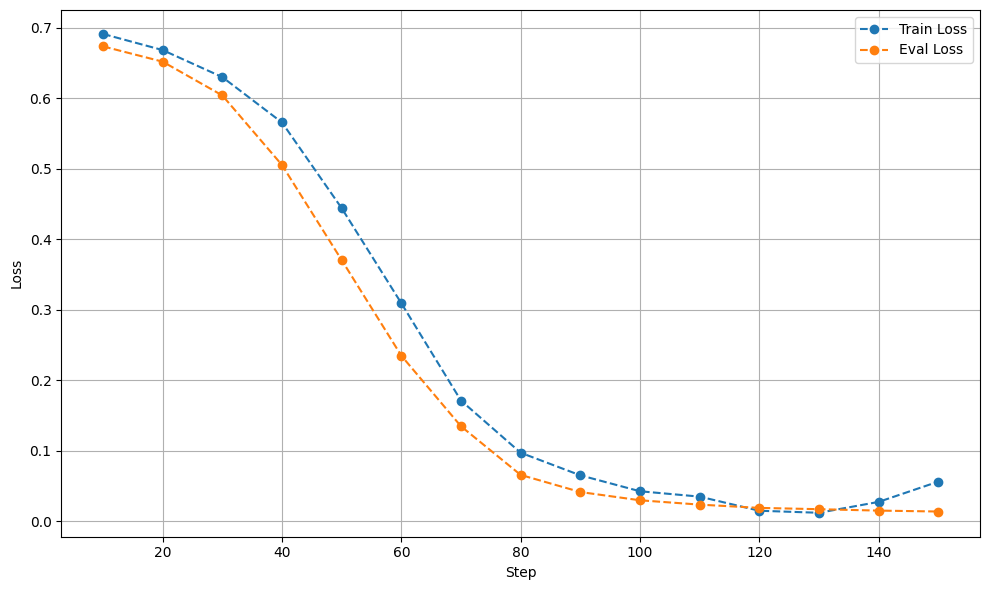

In [401]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "loss" in log and "eval_loss" not in log]
train_losses = [log["loss"] for log in logs if "loss" in log and "eval_loss" not in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10,6))
plt.plot(train_steps, train_losses, label="Train Loss", marker='o', linestyle='--')
plt.plot(eval_steps, eval_losses, label="Eval Loss", marker='o', linestyle='--')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("detector_train_eval_loss.svg")
plt.show()

Metrics: {'accuracy': 0.99949924887331, 'precision': 0.9994998015787477, 'recall': 0.99949924887331, 'f1': 0.9994992724326268, 'f2': 0.9994991976174976, 'roc_auc': np.float64(1.0)}


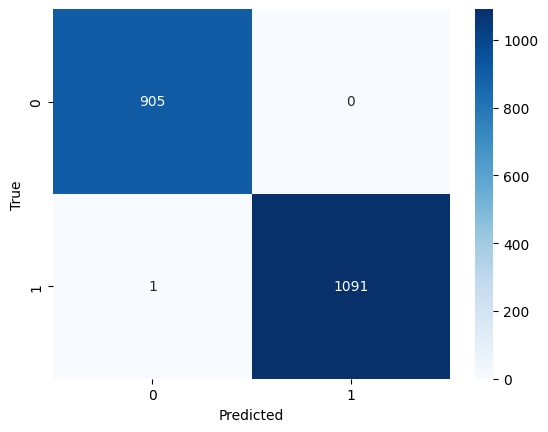

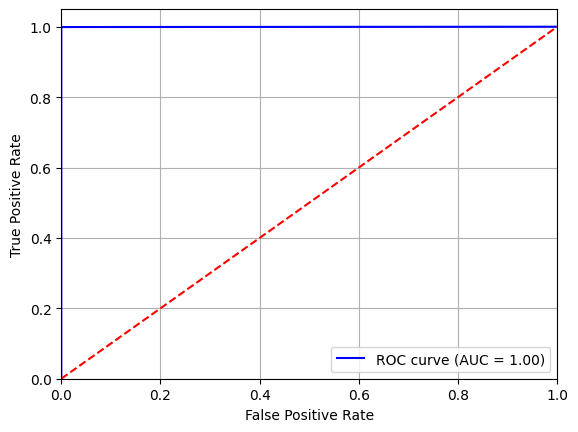

In [402]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_data["test"])
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_auc_curve.svg")
plt.show()

In [370]:
idx = 0

text = tokenized_data["test"][idx]["text"]
print(text)

example = tokenized_data["test"].select([idx])
prediction = trainer.predict(example)

predicted_label = np.argmax(prediction.predictions, axis=1)[0]
true_label = tokenized_data["test"][idx]["label"]
label_map = {0: "REAL", 1: "GENERATED"}
print(f"Predicted: {label_map[predicted_label]} vs. True: {label_map[true_label]}")

Asycfilt.dll shows up on memory dump from compromised system. It has been identified as being part of the same attack chain as Figure 2.


d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Predicted: GENERATED vs. True: GENERATED


### Predict on base model data

In [403]:
base_model_dataset = Dataset.from_pandas(pd.read_json('detection_dataset_base_model.jsonl', lines=True)).filter(lambda example: example["text"] not in dataset)

tokenized_base_model_data = base_model_dataset.map(preprocess_function, batched=True)
tokenized_base_model_data = tokenized_base_model_data.cast_column("label", label_feature)
print("Base Model Data:", Counter(tokenized_base_model_data["label"]))

Filter:   0%|          | 0/3162 [00:00<?, ? examples/s]

Map:   0%|          | 0/3162 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3162 [00:00<?, ? examples/s]

Base Model Data: Counter({0: 1581, 1: 1581})


Metrics: {'accuracy': 0.9949399114484504, 'precision': 0.994990607388854, 'recall': 0.9949399114484504, 'f1': 0.9949397818841152, 'f2': 0.9949337456143519, 'roc_auc': np.float64(0.999949991218458)}


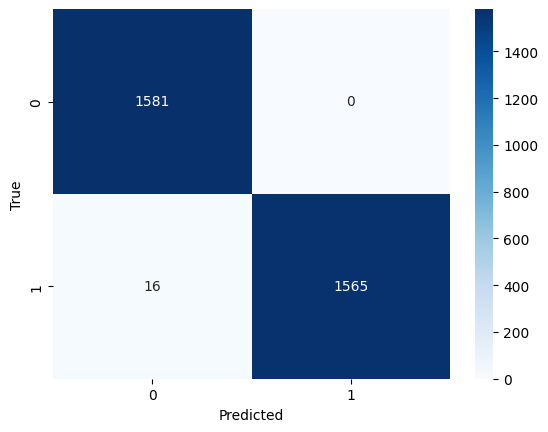

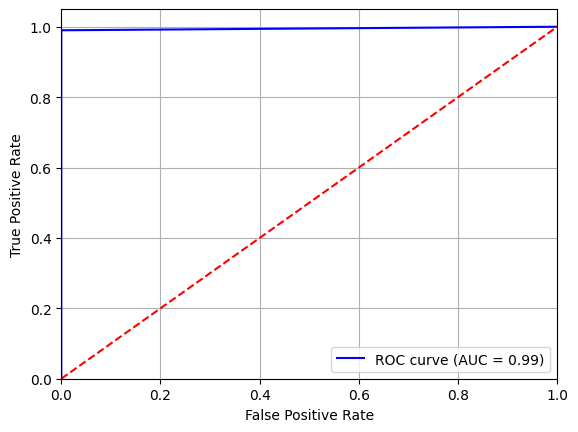

In [404]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_base_model_data)
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_for_base_model.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_auc_curve_for_base_model.svg")
plt.show()

### Predict on survey data

Metrics: {'accuracy': 0.9903846153846154, 'precision': 0.990569526627219, 'recall': 0.9903846153846154, 'f1': 0.9903855044631744, 'f2': 0.9903629898747085, 'roc_auc': np.float64(0.9881613022567518)}


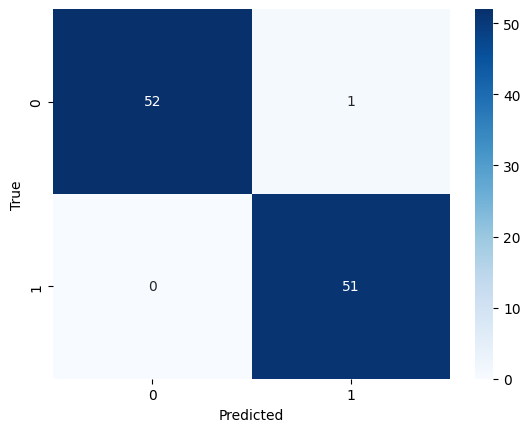

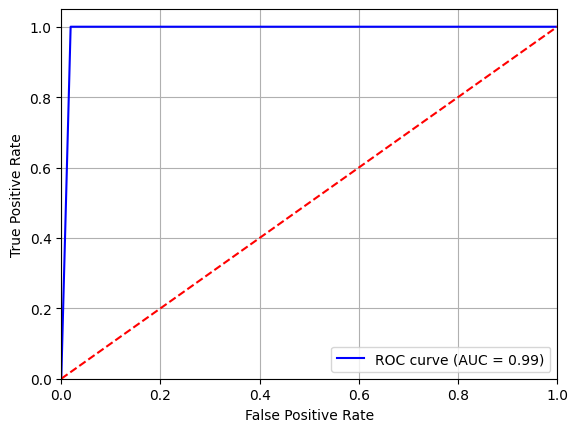

In [405]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_data_survey)
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_for_survey_data.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_auc_curve_for_survey_data.svg")
plt.show()

### Predict on cleaned survey data

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Data: Counter({1: 50, 0: 50})


d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics: {'accuracy': 0.5, 'precision': 0.25, 'recall': 0.5, 'f1': 0.33333333333333326, 'f2': 0.41666666666666674, 'roc_auc': np.float64(0.5412)}


d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


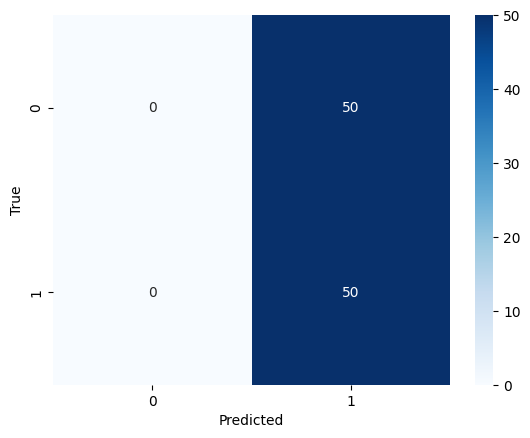

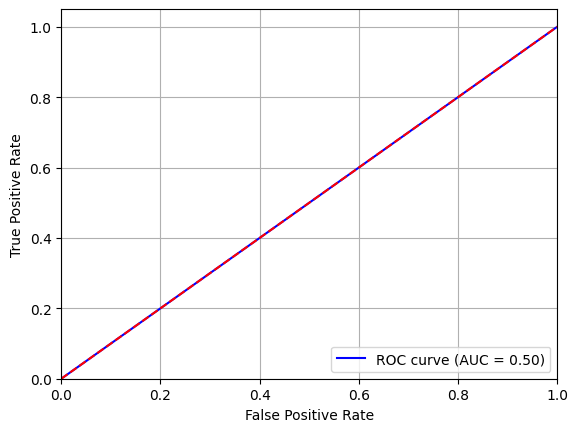

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

test_model_dataset = Dataset.from_pandas(pd.read_json('survey/samples_for_survey.jsonl', lines=True)).filter(lambda example: example["text"] not in dataset)

tokenized_test_data = test_model_dataset.map(preprocess_function, batched=True).cast_column("label", label_feature)
print("Data:", Counter(tokenized_test_data["label"]))

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_test_data)
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_for_survey_data_cleaned.svg")
plt.show()

fpr, tpr, thresholds = roc_curve(labels, np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_auc_curve_for_survey_data_cleaned.svg")
plt.show()